# Testing your causal graph

## Purpose

## Set notebook parameters

In [1]:
# Declare paths to data
DATA_PATH =\
    '../../data/raw/spring_2016_all_bay_area_long_format_plus_cross_bay_col.csv'

# Note the columns of interest for this notebook
MODE_ID_COLUMN = 'mode_id'
OBS_ID_COLUMN = 'observation_id'

TIME_COLUMN = 'total_travel_time'
COST_COLUMN = 'total_travel_cost'
DISTANCE_COLUMN = 'total_travel_distance'
LICENSE_COLUMN = 'num_licensed_drivers'
NUM_AUTOS_COLUMN = 'num_cars'

UTILITY_COLUMNS =\
    [TIME_COLUMN,
     COST_COLUMN,
     DISTANCE_COLUMN,
     LICENSE_COLUMN,
     NUM_AUTOS_COLUMN]

# Note the travel mode of intersest for this notebook
DRIVE_ALONE_ID = 1

## Import needed libraries

In [2]:
# Built-in modules
import sys

# Third party modules
import pandas as pd

# Local modules
sys.path.insert(0, '../../')
import src.viz.sim_cdf as sim_cdf
import src.testing.observable_independence as oi
import src.testing.latent_independence as li

from src.graphs.drive_alone_utility import DRIVE_ALONE_UTILITY
from src.utils import sample_from_factor_model

## Load and describe needed data

In [3]:
# Load the raw data
df = pd.read_csv(DATA_PATH)

# Look at the data being used in this notebook
print(df.loc[df[MODE_ID_COLUMN] == DRIVE_ALONE_ID,
             UTILITY_COLUMNS + [OBS_ID_COLUMN]]
        .head(5)
        .T)

# Create a dataframe with the variables posited
# to make up the drive-alone utility
drive_alone_df =\
    df.loc[df[MODE_ID_COLUMN] == DRIVE_ALONE_ID,
           UTILITY_COLUMNS]

                           0        8        16       24       32
total_travel_time      54.010  39.7800  22.2200  22.3000  47.9500
total_travel_cost       5.714   4.4519   1.6817   1.6817   5.9782
total_travel_distance  30.920  24.0900   9.1000   9.1000  32.3500
num_licensed_drivers    2.000   2.0000   2.0000   2.0000   2.0000
num_cars                2.000   2.0000   2.0000   2.0000   2.0000
observation_id          1.000   2.0000   3.0000   4.0000   5.0000


## Show the posited causal graph

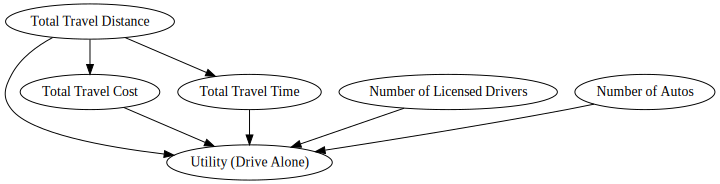

In [4]:
# Draw the causal model being tested
causal_graph = DRIVE_ALONE_UTILITY.draw()
causal_graph.graph_attr.update(size="10,6")
causal_graph

## Marginal independence tests

### Main idea

## Conditional independence tests

### Main idea

### Caveats and pitfalls

## Latent conditional independence tests


### Show the posited causal graph

### Main idea

### Caveats and pitfalls

## Summary